# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from pylab import rcParams

import core.signal_processing as sp
import helpers.dbg as dbg
import vendors.kibot.utils as kut
# import vendors.particle_one.PartTask269_liquidity_analysis_utils as lau

sns.set()

rcParams["figure.figsize"] = (20, 5)

In [3]:
TAU = 2

In [44]:
def get_zscored_prices_diff(price_dict_df, symbol, tau=TAU):
    prices_symbol = price_dict_df[symbol]
    prices_diff = prices_symbol['close'] - prices_symbol['open']
    zscored_prices_diff = sp.rolling_zscore(prices_diff, tau)
    zscored_prices_diff.head()
    abs_zscored_prices_diff = zscored_prices_diff.abs()
    return abs_zscored_prices_diff


def get_top_movements_by_group(price_dict_df,
                               commodity_symbols_kibot,
                               group,
                               n_movements=100):
    zscored_diffs = []
    for symbol in commodity_symbols_kibot[group]:
        zscored_diff = get_zscored_prices_diff(price_dict_df, symbol)
        zscored_diffs.append(zscored_diff)
    zscored_diffs = pd.concat(zscored_diffs, axis=1)
    mean_zscored_diffs = zscored_diffs.mean(axis=1, skipna=True)
    return mean_zscored_diffs.sort_values(ascending=False).head(n_movements)


def get_top_movements_for_symbol(price_dict_df,
                                 symbol,
                                 tau=TAU,
                                 n_movements=100):
    zscored_diffs = get_zscored_prices_diff(price_dict_df, symbol, tau=tau)
    return zscored_diffs.sort_values(ascending=False).head(n_movements)

# Load CME metadata

In [5]:
# Change this to library code from #269 once it is merged into master

In [6]:
_PRODUCT_SPECS_PATH = "/data/prices/product_slate_export_with_contract_specs_20190905.csv"
product_list = pd.read_csv(_PRODUCT_SPECS_PATH)

In [7]:
product_list.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,...,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,ZT,NaN,26,2-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ES,ES,NaN,ES,E-mini S&P 500 Futures,Equities,US Index,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
product_list['Product Group'].value_counts()

Energy           892
Equities         100
Agriculture       57
FX                55
Metals            44
Interest Rate     30
Name: Product Group, dtype: int64

In [9]:
product_list.set_index('Product Group', inplace=True)

In [10]:
commodity_groups = ['Energy', 'Agriculture', 'Metals']

In [11]:
commodity_symbols = {
    group: product_list.loc[group]['Globex'].values
    for group in commodity_groups
}

In [12]:
commodity_symbols

{'Energy': array(['CL', 'NG', 'NN', 'N9L', 'D2L', 'HO', 'RB', 'H2L', 'HH', 'BZ',
        'V3L', 'BK', 'CSX', 'HTT', 'B0', 'NPG', 'WTT', 'B6L', 'E4L', 'HP',
        'AL1', 'AFF', 'EJL', 'LT', 'AD0', 'A1R', 'R7L', 'D4L', 'AW6', 'CU',
        'ADB', 'AC0', 'L3L', 'A4P', 'ME', 'CY', 'WOL', 'A8K', 'T7K', 'ZGL',
        'MTF', 'LPS', 'T3L', 'AE5', 'AYV', 'MFB', 'AU6', 'RBB', 'AWJ',
        'POL', 'A7Q', 'IDL', 'PWL', 'AZ9', 'RVR', 'ZJL', 'TL', 'A46', 'GZ',
        'RLX', 'K4L', 'FTL', 'HOB', 'GCU', 'CRB', 'WCW', 'AOL', 'JDL',
        'EN', 'AA6', 'PD', 'AGA', 'FO', 'N1B', 'NOI', 'MPX', 'NHN', 'NL',
        'JKM', 'MTS', 'AB3', 'NR', 'AH3', 'AP8', 'A7E', 'PGN', 'AFH',
        'AZ1', 'A8I', 'MNC', 'UV', 'SE', 'MAF', 'B7H', 'J4L', 'AYX', 'QM',
        'D3L', 'IN', 'MEO', 'QG', 'EXR', 'PM', 'TTF', 'MFF', 'PGG', 'D7L',
        'BOO', 'MXB', 'EVC', 'A5C', 'AA8', 'EWG', 'HB', 'A8O', 'RKA',
        'ARE', 'GCI', 'A1M', 'AL6', 'A1L', 'A0D', 'MBR', 'APS', 'N3L',
        'JET', 'VR', 'A9N', 'PH', 'PEL'

# Load kibot commodity daily prices

In [13]:
daily_metadata = kut.read_metadata2()
daily_metadata.head(3)

,Symbol,Link,Description
All_Futures_Contracts_daily.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [14]:
len(daily_metadata['Symbol'])

14962

In [15]:
daily_metadata['Symbol'].nunique()

14962

In [16]:
len(commodity_symbols['Energy'])

892

In [17]:
energy_symbols_kibot = np.intersect1d(daily_metadata['Symbol'].values,
                                      commodity_symbols['Energy'])
energy_symbols_kibot

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [18]:
len(energy_symbols_kibot)

23

In [19]:
commodity_symbols_kibot = {
    group: np.intersect1d(daily_metadata['Symbol'].values,
                          commodity_symbols[group])
    for group in commodity_symbols.keys()
}

In [20]:
commodity_symbols_kibot

{'Energy': array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
        'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
        'TM', 'TW'], dtype=object),
 'Agriculture': array(['GF', 'HE', 'LE', 'TT', 'ZCT', 'ZLT', 'ZMT', 'ZWT'], dtype=object),
 'Metals': array(['GC', 'GCK', 'HG', 'HGT', 'MGC', 'PA', 'PL', 'QC', 'QI', 'QO',
        'SI', 'SIL', 'UX'], dtype=object)}

In [21]:
{
    group: len(commodity_symbols_kibot[group])
    for group in commodity_symbols_kibot.keys()
}

{'Energy': 23, 'Agriculture': 8, 'Metals': 13}

In [22]:
comm_list = []
for comm_group in commodity_symbols_kibot.values():
    comm_list.extend(list(comm_group))
comm_list[:5]

['ALM', 'BB', 'BZ', 'CCM', 'CL']

In [23]:
file_name = "/data/kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"

daily_price_dict_df = kut.read_multiple_symbol_data(comm_list,
                                                    file_name,
                                                    nrows=None)

daily_price_dict_df["CL"].tail(2)

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


# Largest movements for a specific symbol

In [24]:
symbol = "CL"

In [25]:
cl_prices = daily_price_dict_df[symbol]

In [26]:
cl_prices_diff = cl_prices['close'] - cl_prices['open']

In [27]:
zscored_cl_prices_diff = sp.rolling_zscore(cl_prices_diff, TAU)
zscored_cl_prices_diff.head()

date
1996-08-16         NaN
1996-08-19   -1.267490
1996-08-20   -1.404842
1996-08-21   -0.924066
1996-08-22    1.088283
dtype: float64

In [28]:
abs_zscored_cl_prices_diff = zscored_cl_prices_diff.abs()

In [29]:
abs_zscored_cl_prices_diff.max()

1.5777263662653875

In [30]:
top_100_movemets_cl = abs_zscored_cl_prices_diff.sort_values(
    ascending=False).head(100)

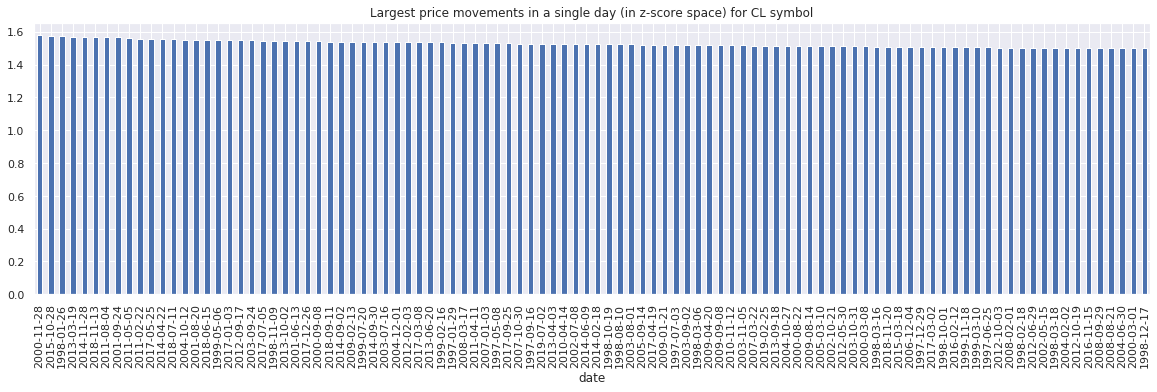

In [31]:
top_100_movemets_cl.plot(kind='bar')
ax = plt.gca()
xlabels = [item.get_text()[:10] for item in ax.get_xticklabels()]
ax.set_xticklabels(xlabels)
plt.title(
    f'Largest price movements in a single day (in z-score space) for {symbol} symbol'
)
plt.show()

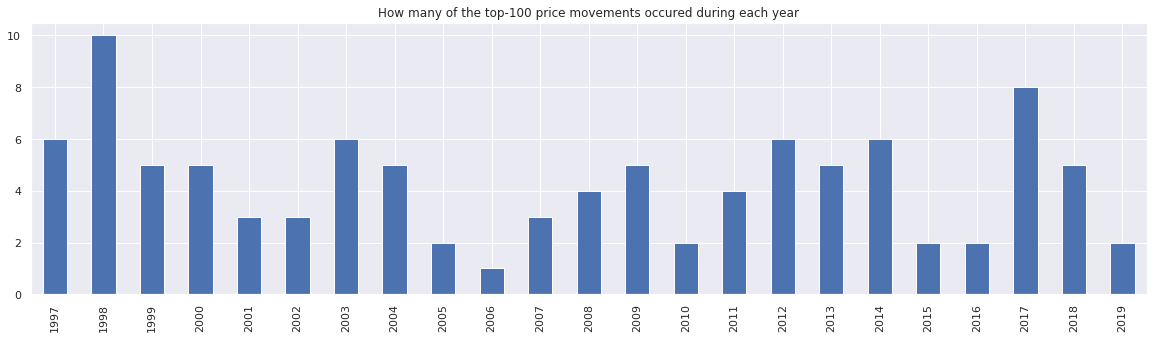

In [32]:
top_100_movemets_cl.index.year.value_counts(sort=False).plot(kind='bar')
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

# Largest movement for energy group

In [33]:
group = 'Energy'

In [34]:
commodity_symbols_kibot[group]

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [35]:
zscored_diffs = []
for symbol in commodity_symbols_kibot[group]:
    zscored_diff = get_zscored_prices_diff(daily_price_dict_df, symbol)
    zscored_diffs.append(zscored_diff)

In [36]:
zscored_diffs = pd.concat(zscored_diffs, axis=1)
zscored_diffs.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
date,,,,,,,,,,,,,,,,,,,,,
1995-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-30,NaN,NaN,NaN,NaN,NaN,NaN,1.267490,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-31,NaN,NaN,NaN,NaN,NaN,NaN,1.210127,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-11-01,NaN,NaN,NaN,NaN,NaN,NaN,1.284967,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-11-02,NaN,NaN,NaN,NaN,NaN,NaN,1.423710,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
mean_zscored_diffs = zscored_diffs.mean(axis=1, skipna=True)

In [38]:
mean_zscored_diffs.head()

date
1995-10-27         NaN
1995-10-30    1.267490
1995-10-31    1.210127
1995-11-01    1.284967
1995-11-02    1.423710
dtype: float64

In [39]:
mean_zscored_diffs.tail()

date
2019-07-15    0.686616
2019-07-16    0.897046
2019-07-17    0.592995
2019-07-18    0.868561
2019-07-19    0.899710
dtype: float64

In [40]:
mean_zscored_diffs.sort_values(ascending=False).head(100)

date
2002-01-21    1.561397
1999-02-15    1.531754
1998-05-25    1.498766
1997-06-25    1.496382
1998-03-18    1.478831
                ...   
1997-08-12    1.228262
1998-11-02    1.227122
1998-04-22    1.226375
2002-05-15    1.224227
1998-09-17    1.221376
Length: 100, dtype: float64

# Get largest movements for each group

In [41]:
top_100_movements_by_group = {
    group: get_top_movements_by_group(daily_price_dict_df,
                                      commodity_symbols_kibot, group)
    for group in commodity_symbols_kibot.keys()
}

In [46]:
top_100_movements_by_group.keys()

dict_keys(['Energy', 'Agriculture', 'Metals'])

In [49]:
top_100_movements_by_group['Energy'].head()

date
2002-01-21    1.561397
1999-02-15    1.531754
1998-05-25    1.498766
1997-06-25    1.496382
1998-03-18    1.478831
dtype: float64

In [48]:
top_100_movements_by_group['Agriculture'].head()

date
2017-01-02    1.442423
2014-05-26    1.422618
2017-01-16    1.413989
2005-01-03    1.402492
2014-02-03    1.395559
dtype: float64

In [47]:
top_100_movements_by_group['Metals'].head()

date
1994-01-25    1.585327
1994-02-14    1.581903
2011-11-24    1.580149
2014-07-04    1.576312
2011-01-17    1.559374
dtype: float64

# 5-minute movements

In [51]:
minutely_metadata = kut.read_metadata1()

In [52]:
minutely_metadata.head()

,Symbol,Link,Description
All_Futures_Contracts_1min.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019
4,JYG18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN FEBRUARY 2018
5,JYG19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN FEBRUARY 2019


In [59]:
np.array_equal(minutely_metadata['Symbol'].values, minutely_metadata['Symbol'].values)

True

In [ ]:
file_name = "/data/kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"

minutely_price_dict_df = kut.read_multiple_symbol_data(comm_list,
                                                       file_name,
                                                       nrows=None)

minutely_price_dict_df["CL"].tail(2)

/home/julia/.conda/envs/p1_develop/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
minutely_price_dict_df['CL'].head()

In [ ]:
five_min_prices = minutely_price_dict_df['CL'].set_index('datetime').resample('5Min').sum()